In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

SELECT date 
FROM Measurement
ORDERBY date DESC
Limit 1

SELECT MAX(date)
FROM Measurement


In [9]:
# Find the most recent date in the data set.
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()

In [10]:
# convert to date
most_recent_date = dt.date.fromisoformat(most_recent_date_str)

SELECT date, prcp 
FROM measurements
WHERE date >= start_date

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date = most_recent_date - dt.timedelta(days = 365)

# Perform a query to retrieve the date and precipitation scores
data = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date >= start_date).\
    group_by(Measurement.date).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(data, columns=["date", "prcp"]).sort_values("date")
precipitation_clean = precipitation.dropna(how='any')
# Sort the dataframe by date
precipitation_clean_sort = precipitation_clean.sort_values(["date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_clean_sort.head()

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


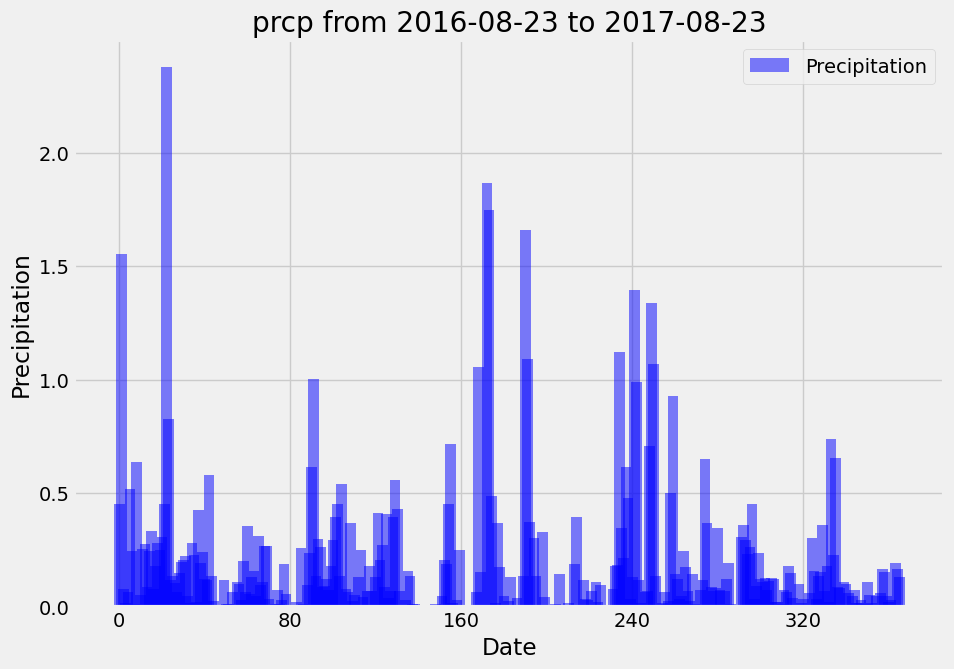

<Figure size 640x480 with 0 Axes>

In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
xx = precipitation_clean_sort.index.tolist()
yy = precipitation_clean_sort['prcp'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
            
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"prcp from {start_date} to {most_recent_date}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

# save figure
plt.savefig("../graphs/Fig1.png")

In [21]:
precipitation_clean_sort.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
select = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*select).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ma_select = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station = session.query(*ma_select).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

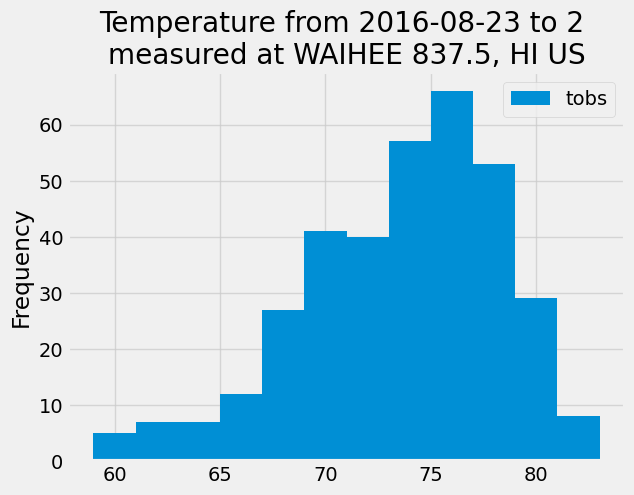

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= start_date).all()
temperatures = list(np.ravel(past_year))

select_py = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
past_year_query = session.query(*select_py).all()
ma_station = pd.DataFrame(past_year_query, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = ma_station.loc[ma_station["Station"] == active_stations[0][0], "Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {start_date} to {most_recent_date_str[0]} \nmeasured at {station_name}")
plt.legend()
# save figure
plt.savefig("../graphs/Fig2.png")

# Close Session

In [37]:
# Close Session
session.close()